In [1]:
import os
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.documentintelligence.models import DocumentAnalysisFeature
from azure.ai.documentintelligence.models import AnalyzeResult, DocumentParagraph
from azure.ai.documentintelligence.models import AnalyzeDocumentRequest
from PIL import Image, ImageDraw, ImageFont
import math
import openai
from openai import AzureOpenAI
from dotenv import load_dotenv
import cv2
from modelscope.outputs import OutputKeys
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks
from collections import defaultdict
from typing import List, Dict, Any
import json
import asyncio
import pathlib

/home/azureuser/anaconda3/envs/imagetranslator/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-10 06:27:31.862484: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-10 06:27:32.137147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736490452.230016    8316 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736490452.248672    8316 cu

In [2]:
endpoint = os.environ.get("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT")
key = os.environ.get("AZURE_DOCUMENT_INTELLIGENCE_SUBSCRIPTION_KEY")

azure_openai_api_endpoint = os.environ.get("AZURE_OPENAI_API_ENDPOINT")
azure_openai_api_key = os.environ.get("AZURE_OPENAI_API_KEY")
azure_openai_api_version = os.environ.get("AZURE_OPENAI_API_VERSION")
model = os.environ.get("AZURE_OPENAI_MODEL")

In [3]:
data_path = "./data"
image_name = "WechatIMG125.jpg"
image_path = os.path.join(data_path, image_name)

In [ ]:
# Reduce image width and height to below 2000 pixels
img = cv2.imread(image_path)
scale_percent = 1152 / img.shape[1]
width = int(img.shape[1] * scale_percent)
height = int(img.shape[0] * scale_percent)
dim = (width, height)
resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
path, filename = os.path.split(image_path)
base_filename, file_extension = os.path.splitext(filename)
resized_image_path = os.path.join(path, base_filename + "_resized" + file_extension)
cv2.imwrite(resized_image_path, resized)

True

In [5]:
pil_image = Image.open(image_path)

In [6]:
pil_image.width, pil_image.height

(5712, 4284)

In [31]:
def get_words(page, line):
    result = []
    for word in page.words:
        if _in_span(word, line.spans):
            result.append(word)
    return result

def _get_styled_text(styles, content):
    # Iterate over the styles and merge the spans from each style.
    spans = [span for style in styles for span in style.spans]
    spans.sort(key=lambda span: span.offset)
    return ",".join([content[span.offset : span.offset + span.length] for span in spans])

# To learn the detailed concept of "span" in the following codes, visit: https://aka.ms/spans 
def _in_span(paragraph: DocumentParagraph, all_spans):
    for span in all_spans:
        for p_span in paragraph['spans']:
            if p_span.offset >= span.offset and (p_span.offset + p_span.length) <= (span.offset + span.length):
                return True
        # if paragraph.span.offset >= span.offset and (word.span.offset + word.span.length) <= (span.offset + span.length):
        #     return True
    return False

def _calculate_rotation(bounding_polygon):
    # Calculate the angle of the bounding polygon
    # The bounding polygon is a quadrilateral represented by four points
    # The angle is calculated by the arctangent of the slope of the line formed by the first and last point of the polygon
    # The angle is then converted from radians to degrees
    # The angle is then normalized to be between 0 and 360 degrees
    first_point = (bounding_polygon[0], bounding_polygon[1])
    second_point = (bounding_polygon[2], bounding_polygon[3])
    third_point = (bounding_polygon[4], bounding_polygon[5])
    last_point = (bounding_polygon[6], bounding_polygon[7])
    width = math.sqrt((first_point[0] - second_point[0]) ** 2 + (first_point[1] - second_point[1]) ** 2)
    height = math.sqrt((second_point[0] - third_point[0]) ** 2 + (second_point[1] - third_point[1]) ** 2)
    if width > height:
        angle = math.degrees(math.atan2(second_point[1] - first_point[1], second_point[0] - first_point[0]))
    else:
        angle = math.degrees(math.atan2(third_point[1] - second_point[1], third_point[0] - second_point[0]))
    return angle if angle >= 0 else 360 + angle

def _get_paragraph_styles(paragraphs: List[DocumentParagraph], ocr_result: AnalyzeResult):
    all_styles = ocr_result.styles
    for paragraph in paragraphs:
        print(f"Analyzing paragraph: {paragraph['original_text']}")
        print(f"Paragraph spans: {paragraph['spans']}")
        paragraph['rotation'] = _calculate_rotation(paragraph['bounding_polygon'])
        for span in paragraph['spans']:
            for style in all_styles:
                for s_span in style.spans:
                    if span.offset >= s_span.offset and (span.offset + span.length) <= (s_span.offset + s_span.length):
                        if style.similar_font_family:
                            print(f"Found font family: {style.similar_font_family} in paragraph: {paragraph['original_text']}, span: {span}")
                            paragraph['similar_font_family'] = style.similar_font_family
                        if style.font_style:
                            print(f"Found font style: {style.font_style} in paragraph: {paragraph['original_text']}, span: {span}")
                            paragraph['font_style'] = style.font_style.value
                        if style.font_weight:
                            print(f"Found font weight: {style.font_weight} in paragraph: {paragraph['original_text']}, span: {span}")
                            paragraph['font_weight'] = style.font_weight.value
                        if style.color:
                            print(f"Found font color: {style.color} in paragraph: {paragraph['original_text']}, span: {span}")
                            paragraph['font_color'] = style.color
                        if style.background_color:
                            print(f"Found font background color: {style.background_color} in paragraph: {paragraph['original_text']}, span: {span}")
                            paragraph['font_background_color'] = style.background_color
    return paragraphs


def get_font_family(paragraph: DocumentParagraph, result: AnalyzeResult):
    for style in result.styles:
        if _in_span(paragraph, style.spans):
            print(style)
            return style.similar_font_family
    return None

def get_font_style(paragraph: DocumentParagraph, result: AnalyzeResult):
    for style in result.styles:
        if _in_span(paragraph, style.spans):
            return style.font_style
    return None

def get_font_weight(paragraph: DocumentParagraph, result: AnalyzeResult):
    for style in result.styles:
        if _in_span(paragraph, style.spans):
            return style.font_weight
    return None

def get_font_color(paragraph: DocumentParagraph, result: AnalyzeResult):
    for style in result.styles:
        if _in_span(paragraph, style.spans):
            return style.color
    return None

def get_font_background_color(paragraph: DocumentParagraph, result: AnalyzeResult):
    for style in result.styles:
        if _in_span(paragraph, style.spans):
            return style.background_color
    return None

def _get_line_styles(index, line, result):
    all_styles = result.styles
    line_dict = {}
    for style in all_styles:
        for span in line.spans:
            for s_span in style.spans:
                if span.offset >= s_span.offset and (span.offset + span.length) <= (s_span.offset + s_span.length):
                    if style.similar_font_family:
                        print(f"Found font family: {style.similar_font_family} in paragraph: {line.content}, span: {span}")
                        line_dict['similar_font_family'] = style.similar_font_family
                    if style.font_style:
                        print(f"Found font style: {style.font_style} in paragraph: {line.content}, span: {span}")
                        line_dict['font_style'] = style.font_style.value
                    if style.font_weight:
                        print(f"Found font weight: {style.font_weight} in paragraph: {line.content}, span: {span}")
                        line_dict['font_weight'] = style.font_weight.value
                    if style.color:
                        print(f"Found font color: {style.color} in paragraph: {line.content}, span: {span}")
                        line_dict['font_color'] = style.color
                    if style.background_color:
                        print(f"Found font background color: {style.background_color} in paragraph: {line.content}, span: {span}")
                        line_dict['font_background_color'] = style.background_color
    line_dict["index"] = index
    line_dict["original_text"] = line.content
    line_dict["bounding_polygon"] = line.polygon
    line_dict["spans"] = line.spans
    return line_dict

def analyze_layout(image_path: str):

    document_intelligence_client = DocumentIntelligenceClient(
        endpoint=endpoint, credential=AzureKeyCredential(key)
    )

    
    with open(image_path, "rb") as f:
        poller = document_intelligence_client.begin_analyze_document(
            "prebuilt-read", body=f, content_type="image/jpg",features=[DocumentAnalysisFeature.LANGUAGES, DocumentAnalysisFeature.STYLE_FONT]
        )

    result: AnalyzeResult = poller.result()
    translate_keywords = []

    # similar_font_families = defaultdict(list)  # e.g., 'Arial, sans-serif
    # font_styles = defaultdict(list)  # e.g, 'italic'
    # font_weights = defaultdict(list)  # e.g., 'bold'
    # font_colors = defaultdict(list)  # in '#rrggbb' hexadecimal format
    # font_background_colors = defaultdict(list)  # in '#rrggbb' hexadecimal format
    
    # for style in result.styles:
    #     if style.similar_font_family:
    #         similar_font_families[style.similar_font_family].append(style)
    #     if style.font_style:
    #         font_styles[style.font_style].append(style)
    #     if style.font_weight:
    #         font_weights[style.font_weight].append(style)
    #     if style.color:
    #         font_colors[style.color].append(style)
    #     if style.background_color:
    #         font_background_colors[style.background_color].append(style)

    # print(f"Detected {len(similar_font_families)} font families:")
    # for font_family, styles in similar_font_families.items():
    #     print(f"- Font family: '{font_family}'")
    #     print(f"  Text: '{_get_styled_text(styles, result.content)}'")

    # print(f"\nDetected {len(font_styles)} font styles:")
    # for font_style, styles in font_styles.items():
    #     print(f"- Font style: '{font_style}'")
    #     print(f"  Text: '{_get_styled_text(styles, result.content)}'")

    # print(f"\nDetected {len(font_weights)} font weights:")
    # for font_weight, styles in font_weights.items():
    #     print(f"- Font weight: '{font_weight}'")
    #     print(f"  Text: '{_get_styled_text(styles, result.content)}'")

    # print(f"\nDetected {len(font_colors)} font colors:")
    # for font_color, styles in font_colors.items():
    #     print(f"- Font color: '{font_color}'")
    #     print(f"  Text: '{_get_styled_text(styles, result.content)}'")

    # print(f"\nDetected {len(font_background_colors)} font background colors:")
    # for font_background_color, styles in font_background_colors.items():
    #     print(f"- Font background color: '{font_background_color}'")
    #     print(f"  Text: '{_get_styled_text(styles, result.content)}'")

    print("----------------------------------------")
    
    # for para_index, paragraph in enumerate(result.paragraphs):
    #     print(f"...Paragraph #{para_index} has text '{paragraph.content}'")
    #     print(f"with bounding polygon '{paragraph.bounding_regions[0].polygon}'")
    #     translate_keywords.append(
    #         {
    #             "index": para_index,
    #             "original_text": paragraph.content,
    #             "bounding_polygon": paragraph.bounding_regions[0].polygon,
    #             "spans": paragraph.spans,
    #         }
    #     )
    
    # translate_keywords = _get_paragraph_styles(translate_keywords, result)

    # if result.styles:
    #     for style in result.styles:
    #         if style.is_handwritten:
    #             print("Found the following handwritten content: ")
    #             print(",".join([result.content[span.offset : span.offset + span.length] for span in style.spans]))
    #         if style.font_style:
    #             print(f"The document contains '{style.font_style}' font style, applied to the following text: ")
    #             print(",".join([result.content[span.offset : span.offset + span.length] for span in style.spans]))

    for page in result.pages:
        print(f"----Analyzing layout from page #{page.page_number}----")
        print(
            f"Page has width: {page.width} and height: {page.height}, measured with unit: {page.unit}"
        )

        if page.lines:
            for line_idx, line in enumerate(page.lines):
                # words = get_words(page, line)
                # print(
                #     f"...Line # {line_idx} has word count {len(words)} and text '{line.content}' "
                #     f"within bounding polygon '{line.polygon}'"
                # )
                # translate_keywords.append((line.content, line.polygon))

                # for word in words:
                #     print(
                #         f"......Word '{word.content}' has a confidence of {word.confidence}"
                #     )
                translate_keywords.append(_get_line_styles(line_idx, line, result))

    #     if page.selection_marks:
    #         for selection_mark in page.selection_marks:
    #             print(
    #                 f"Selection mark is '{selection_mark.state}' within bounding polygon "
    #                 f"'{selection_mark.polygon}' and has a confidence of {selection_mark.confidence}"
    #             )

    if result.tables:
        for table_idx, table in enumerate(result.tables):
            print(
                f"Table # {table_idx} has {table.row_count} rows and "
                f"{table.column_count} columns"
            )
            if table.bounding_regions:
                for region in table.bounding_regions:
                    print(
                        f"Table # {table_idx} location on page: {region.page_number} is {region.polygon}"
                    )
            for cell in table.cells:
                print(
                    f"...Cell[{cell.row_index}][{cell.column_index}] has text '{cell.content}'"
                )
                if cell.bounding_regions:
                    for region in cell.bounding_regions:
                        print(
                            f"...content on page {region.page_number} is within bounding polygon '{region.polygon}'"
                        )

    print("----------------------------------------")
    return translate_keywords

def translate_using_gpt(text, translate_to_language):
    azure_openai_client = AzureOpenAI(azure_endpoint=azure_openai_api_endpoint, api_key=azure_openai_api_key, api_version=azure_openai_api_version)
    messages = [
        {
            "role": "system",
            "content": "You are a translator to help translate the text into " + translate_to_language + ". Only translate the text, do not add any additional information. If you can't translate the text, output original text."
        },{
            "role": "user",
            "content": f"translate the following text into {translate_to_language}: "+text
        }
    ]
    result = azure_openai_client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=0
            )
    return result.choices[0].message.content

In [32]:
ocr_result = analyze_layout(resized_image_path)

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://angzou-di-eastus.cognitiveservices.azure.com//documentintelligence/documentModels/prebuilt-read:analyze?api-version=REDACTED&features=REDACTED'
Request method: 'POST'
Request headers:
    'content-type': 'application/octet-stream'
    'Accept': 'application/json'
    'x-ms-client-request-id': 'a7de79e6-cf1c-11ef-8de2-000d3ac9105f'
    'User-Agent': 'azsdk-python-ai-documentintelligence/1.0.0 Python/3.10.15 (Linux-6.8.0-1020-azure-x86_64-with-glibc2.35)'
    'Ocp-Apim-Subscription-Key': 'REDACTED'
A body is sent with the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 202
Response headers:
    'Content-Length': '0'
    'Operation-Location': 'REDACTED'
    'x-envoy-upstream-service-time': 'REDACTED'
    'apim-request-id': 'REDACTED'
    'Strict-Transport-Security': 'REDACTED'
    'x-content-type-options': 'REDACTED'
    'x-ms-region': 'REDACTED'
    'Date': 'Fri, 10 Jan 2025 06:32:2

----------------------------------------
----Analyzing layout from page #1----
Page has width: 1152.0 and height: 864.0, measured with unit: pixel
Found font color: #595555 in paragraph: 女, span: {'offset': 0, 'length': 1}
Found font background color: #b2aeac in paragraph: 女, span: {'offset': 0, 'length': 1}
Found font color: #79857d in paragraph: % 编辑 8, span: {'offset': 2, 'length': 6}
Found font background color: #aeb6ae in paragraph: % 编辑 8, span: {'offset': 2, 'length': 6}
Found font style: normal in paragraph: % 编辑 8, span: {'offset': 2, 'length': 6}
Found font weight: bold in paragraph: % 编辑 8, span: {'offset': 2, 'length': 6}
Found font family: BIZ UDGothic, SimHei, sans-serif in paragraph: % 编辑 8, span: {'offset': 2, 'length': 6}
Found font family: BIZ UDGothic, SimHei, sans-serif in paragraph: 大语言模型通识, span: {'offset': 9, 'length': 7}
Found font color: #493569 in paragraph: 大语言模型通识, span: {'offset': 9, 'length': 7}
Found font background color: #968a96 in paragraph: 大语言模型通识, s

In [33]:
ocr_result

[{'font_color': '#595555',
  'font_background_color': '#b2aeac',
  'index': 0,
  'original_text': '女',
  'bounding_polygon': [650.0, 8.0, 671.0, 7.0, 671.0, 25.0, 650.0, 25.0],
  'spans': [{'offset': 0, 'length': 1}]},
 {'font_color': '#79857d',
  'font_background_color': '#aeb6ae',
  'font_style': 'normal',
  'font_weight': 'bold',
  'similar_font_family': 'BIZ UDGothic, SimHei, sans-serif',
  'index': 1,
  'original_text': '% 编辑 8',
  'bounding_polygon': [1093.0, 12.0, 1150.0, 12.0, 1151.0, 28.0, 1093.0, 29.0],
  'spans': [{'offset': 2, 'length': 6}]},
 {'similar_font_family': 'BIZ UDGothic, SimHei, sans-serif',
  'font_color': '#493569',
  'font_background_color': '#968a96',
  'font_style': 'normal',
  'font_weight': 'bold',
  'index': 2,
  'original_text': '大语言模型通识',
  'bounding_polygon': [40.0, 227.0, 148.0, 228.0, 148.0, 242.0, 40.0, 242.0],
  'spans': [{'offset': 9, 'length': 7}]},
 {'font_style': 'normal',
  'font_weight': 'bold',
  'font_color': '#59496d',
  'font_background_c

In [23]:
new_image = ImageDraw.Draw(pil_image)
box = [2728.0, 49.0, 3164.0, 49.0, 3164.0, 187.0, 2728.0, 187.0]
new_image.polygon(box, outline="red", width=1)
# new_image.polygon([400, 618, 400, 608, 408, 608, 408, 618], outline="yellow", width=1)
new_image.circle((box[0], box[1]), fill="red", radius=10)
new_image.circle((box[2], box[3]), fill="green", radius=10)
new_image.circle((box[4], box[5]), fill="blue", radius=10)
new_image.circle((box[6], box[7]), fill="yellow", radius=10)

In [9]:
def _draw_mask_box(image, translate_keywords):
    mask = Image.new("RGBA", image.size, color=(0,0,0))
    draw = ImageDraw.Draw(mask)
    for keyword in translate_keywords:
        draw.polygon(keyword["bounding_polygon"], outline="white", width=1, fill="white")
        # draw.circle((keyword["bounding_polygon"][0], keyword["bounding_polygon"][1]), fill="red", radius=10)
        # draw.circle((keyword["bounding_polygon"][2], keyword["bounding_polygon"][3]), fill="green", radius=10)
        # draw.circle((keyword["bounding_polygon"][4], keyword["bounding_polygon"][5]), fill="blue", radius=10)
        # draw.circle((keyword["bounding_polygon"][6], keyword["bounding_polygon"][7]), fill="yellow", radius=10)
    return mask

In [10]:
pil_image_resized = Image.open(resized_image_path)

In [11]:
pil_image_resized.width, pil_image_resized.height

(1152, 864)

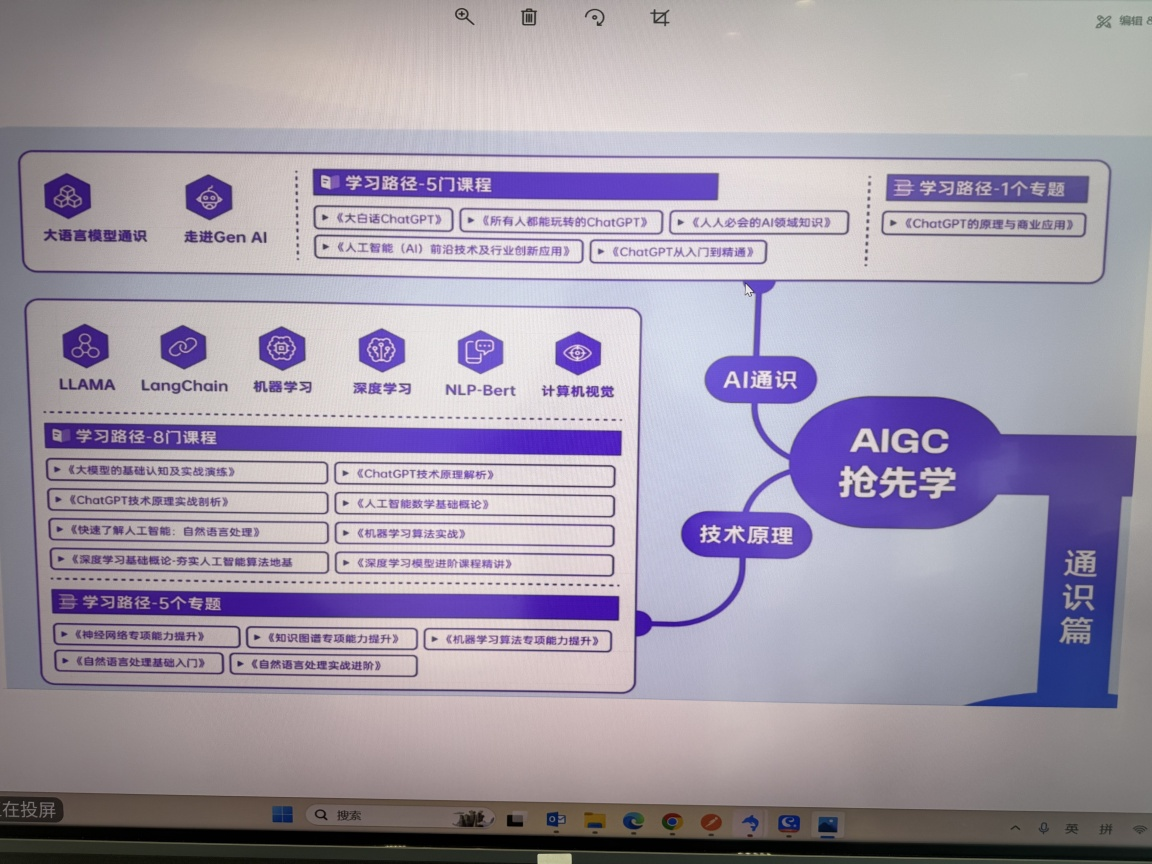

In [12]:
pil_image_resized

In [13]:
pil_mask = _draw_mask_box(pil_image_resized, ocr_result)

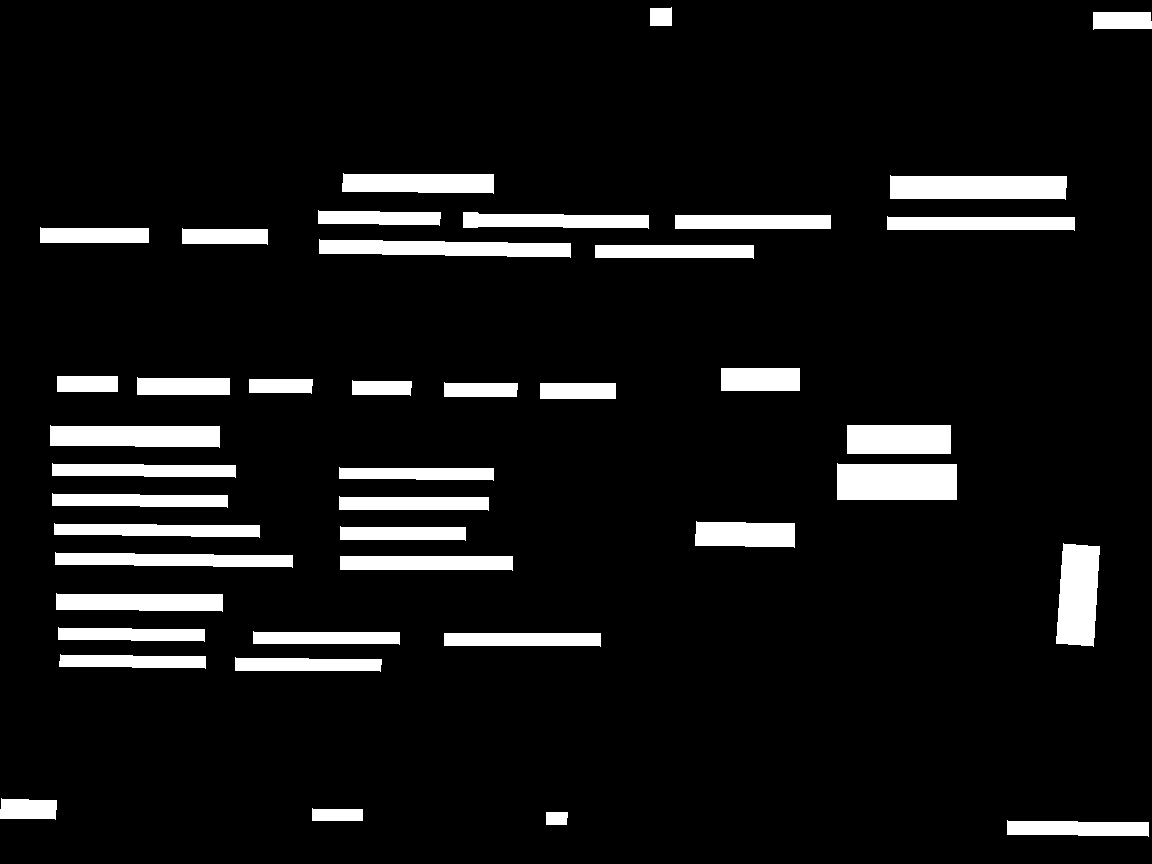

In [14]:
pil_mask

In [15]:
pil_mask.width, pil_mask.height

(1152, 864)

In [16]:
def _text_removal(image, mask):
    input = {
        'img': image,
        'mask': mask,
    }
    inpainting = pipeline(Tasks.image_inpainting, model="damo/cv_fft_inpainting_lama")
    result = inpainting(input)
    vis_img = result[OutputKeys.OUTPUT_IMG]
    cv2.imwrite("inpainting_result.jpg", vis_img)
    vis_img = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGBA)
    removed_text_image = Image.fromarray(vis_img)
    return removed_text_image

In [17]:
pil_mask.save("./data/WechatIMG125_mask.png")

In [18]:
pil_mask.width, pil_mask.height

(1152, 864)

In [19]:
removed_text_image = _text_removal(resized_image_path, "./data/WechatIMG125_mask.png")

2025-01-10 06:28:30,387 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
2025-01-10 06:28:30,817 - modelscope - INFO - initiate model from /home/azureuser/.cache/modelscope/hub/damo/cv_fft_inpainting_lama
2025-01-10 06:28:30,818 - modelscope - INFO - initiate model from location /home/azureuser/.cache/modelscope/hub/damo/cv_fft_inpainting_lama.
2025-01-10 06:28:30,819 - modelscope - INFO - initialize model from /home/azureuser/.cache/modelscope/hub/damo/cv_fft_inpainting_lama
2025-01-10 06:28:30,826 - modelscope - INFO - BaseInpaintingTrainingModule init called, predict_only is False


Loading weights for net_encoder


/home/azureuser/anaconda3/envs/imagetranslator/lib/python3.10/site-packages/modelscope/models/cv/image_inpainting/modules/ade20k/base.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

In [20]:
removed_text_image.width, removed_text_image.height

(1152, 864)

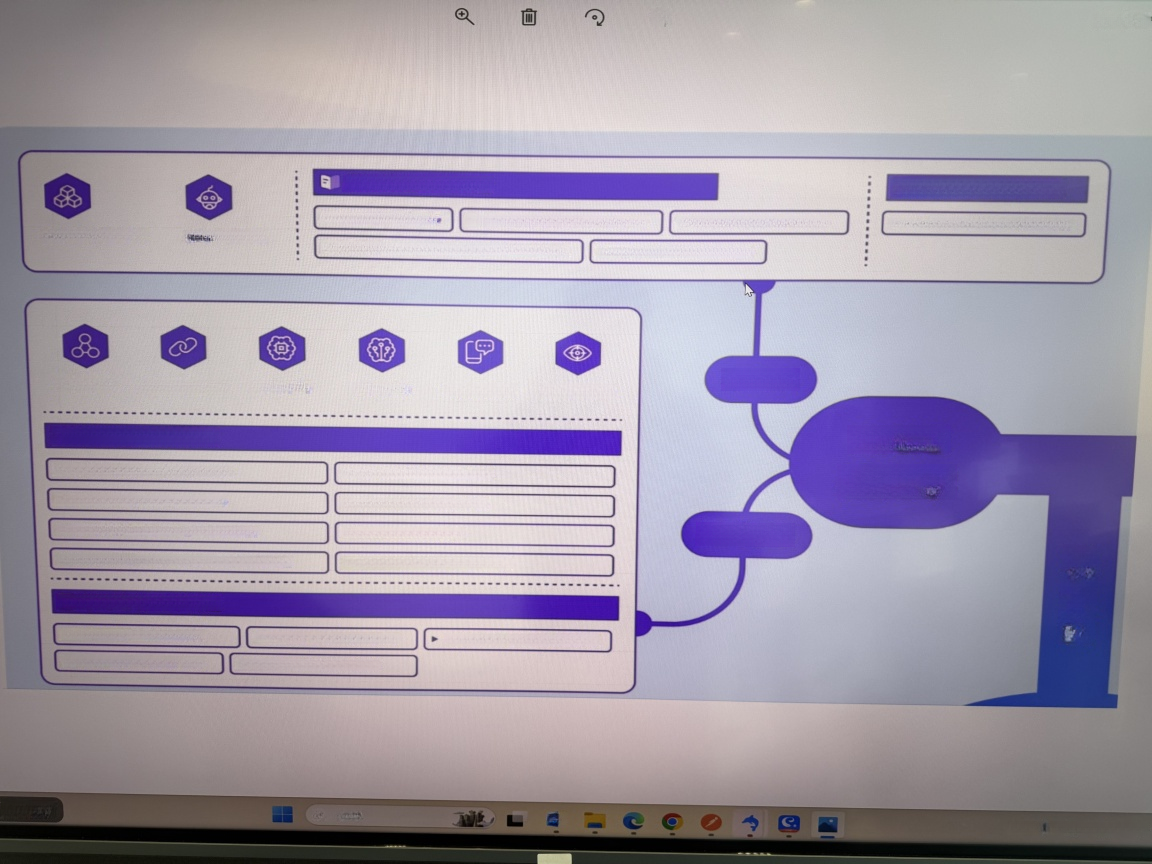

In [21]:
removed_text_image

In [22]:
async def _translate_using_gpt_single(ocr_result: List[Dict], translate_to_language):
    azure_openai_client = AzureOpenAI(azure_endpoint=azure_openai_api_endpoint, api_key=azure_openai_api_key, api_version=azure_openai_api_version)
    messages = [
        {
            "role": "system",
            "content": """
            # ROLE: Translator
            You are a translator to help translate the text into " + {translate_to_language} + ". 
            # INSTRUCTIONS:
            1. Only translate the text, do not add any additional information. 
            2. If the text is already in {translate_to_language}, DO NOT translatetext, output original text.
            3. If it's only simbols, numbers or special characters, DO NOT translate the text, output original text.
            """.format(translate_to_language=translate_to_language)
        },{
            "role": "user",
            "content": f"translate the following text into {translate_to_language}: "+ocr_result['original_text']
        }
    ]
    result = azure_openai_client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=0
            )
    ocr_result['translated_text'] = result.choices[0].message.content
    return ocr_result

def _translate_using_gpt_batch(ocr_result, translate_to_language):
    tasks = []
    for result in ocr_result:
        tasks.append(_translate_using_gpt_single(result, translate_to_language))
    results = asyncio.gather(*tasks)
    return results
    

In [23]:
import nest_asyncio
nest_asyncio.apply()

In [49]:
loop = asyncio.get_event_loop()
translated_result = loop.run_until_complete(_translate_using_gpt_batch(ocr_result, "jp"))

INFO:httpx:HTTP Request: POST https://angzou-openai-eastus2.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-10-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://angzou-openai-eastus2.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-10-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://angzou-openai-eastus2.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-10-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://angzou-openai-eastus2.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-10-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://angzou-openai-eastus2.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-10-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://angzou-openai-eastus2.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-10-01-preview "HTT

In [50]:
translated_result

[{'font_color': '#595555',
  'font_background_color': '#b2aeac',
  'index': 0,
  'original_text': '女',
  'bounding_polygon': [650.0, 8.0, 671.0, 7.0, 671.0, 25.0, 650.0, 25.0],
  'spans': [{'offset': 0, 'length': 1}],
  'translated_text': '女'},
 {'font_color': '#79857d',
  'font_background_color': '#aeb6ae',
  'font_style': 'normal',
  'font_weight': 'bold',
  'similar_font_family': 'BIZ UDGothic, SimHei, sans-serif',
  'index': 1,
  'original_text': '% 编辑 8',
  'bounding_polygon': [1093.0, 12.0, 1150.0, 12.0, 1151.0, 28.0, 1093.0, 29.0],
  'spans': [{'offset': 2, 'length': 6}],
  'translated_text': '% 編集 8'},
 {'similar_font_family': 'BIZ UDGothic, SimHei, sans-serif',
  'font_color': '#493569',
  'font_background_color': '#968a96',
  'font_style': 'normal',
  'font_weight': 'bold',
  'index': 2,
  'original_text': '大语言模型通识',
  'bounding_polygon': [40.0, 227.0, 148.0, 228.0, 148.0, 242.0, 40.0, 242.0],
  'spans': [{'offset': 9, 'length': 7}],
  'translated_text': '大言語モデル通識'},
 {'font_

In [59]:
def _replace_translated_text(image, translated_result):
    translated_image = image.copy()
    background_img = translated_image
    for result in translated_result:
        print(result)
        point_0 = (result["bounding_polygon"][0], result["bounding_polygon"][1])
        point_1 = (result["bounding_polygon"][2], result["bounding_polygon"][3])
        point_2 = (result["bounding_polygon"][4], result["bounding_polygon"][5])
        point_3 = (result["bounding_polygon"][6], result["bounding_polygon"][7])
        im_text = Image.new("RGBA", background_img.size, (0,0,0,0))
        draw = ImageDraw.Draw(im_text)
        translated_text = result['translated_text']
        # draw.polygon(keyword["bounding_polygon"], fill="grey")
        if result.get('font_style') == "bold":
            font = ImageFont.truetype('./arial-unicode-ms-bold.ttf')
        else:
            font = ImageFont.truetype('./arial-unicode-ms-regular.ttf')
        if result.get('font_color'):
            font_color = result['font_color']
        else:
            font_color = "black"
        if result.get('font_background_color'):
            background_color = result['font_background_color']
        else:
            background_color = None
        
        default_font = ImageFont.load_default()
        print("translated text: ", translated_text)
        single_line_text_length, max_single_line = max([(len(s_line), s_line) for s_line in translated_text.split("\n")])
        print("single line text length: ", single_line_text_length)
        
        text_size = draw.textlength(max_single_line, font=default_font)
        max_text_width = max(abs(result["bounding_polygon"][0] - result["bounding_polygon"][2]),abs(result["bounding_polygon"][3] - result["bounding_polygon"][5]))
        max_text_height = max(abs(result["bounding_polygon"][1] - result["bounding_polygon"][3]),abs(result["bounding_polygon"][5] - result["bounding_polygon"][7]))
        max_text_width = max_text_width * 1.05
        max_text_height = max_text_height * 1.05
        if max_text_width < max_text_height:
            t_max_text_width = max_text_width
            max_text_width = max_text_height
            max_text_height = t_max_text_width

        print("max text width: ", max_text_width, "text size: ", text_size)
        # scaling_factor = max_text_width / text_size
        # scaled_font_size = font.size * scaling_factor
        # if scaled_font_size <= 10:
        #     scaled_font_size = text_size/font.size
        # print("scaled font size: ", scaled_font_size)
        # scaled_font_size = 12
        scaled_font_size = 36
        while scaled_font_size > 10:
            if result.get('font_style') == "bold":
                scaled_font = ImageFont.truetype('./arial-unicode-ms-bold.ttf', size=scaled_font_size,layout_engine=ImageFont.Layout.BASIC)
            else:
                scaled_font = ImageFont.truetype('./arial-unicode-ms-regular.ttf', size=scaled_font_size,layout_engine=ImageFont.Layout.BASIC)
            # lines = []
            # line = ""
            # for word in translated_text.split():
            #     proposed_line = line
            #     if line:
            #         proposed_line += " "
            #     proposed_line += word
            #     if font.getlength(proposed_line) <= max_text_width:
            #         line = proposed_line
            #     else:
            #         lines.append(line)
            #         line = word
            # if line:
            #     lines.append(line)
            # translated_text = "\n".join(lines)
            # x1, y1, x2, y2 = draw.multiline_textbbox((0,0), translated_text, font=scaled_font)
            # w, h = x2 - x1, y2 - y1
            # if h <= max_text_height:
            #     break
            if scaled_font.getlength(translated_text) <= max_text_width:
                break
            else:
                scaled_font_size -= 1
        if result.get('font_style') == "bold":
            scaled_font = ImageFont.truetype('./arial-unicode-ms-bold.ttf', size=scaled_font_size)
        else:
            scaled_font = ImageFont.truetype('./arial-unicode-ms-regular.ttf', size=scaled_font_size)

        # coords = (result["bounding_polygon"][0], result["bounding_polygon"][1])
        draw.text((point_0[0],point_0[1]), text=translated_text, font=scaled_font, fill=font_color)
        if result.get('rotation'):
            print("Rotating text by: ", result['rotation'])
            im_text = im_text.rotate(result['rotation'],expand=True)
        # if background_color:
        #     x0 = result["bounding_polygon"][0]
        #     y0 = result["bounding_polygon"][1]
        #     x1 = result["bounding_polygon"][4]
        #     y1 = result["bounding_polygon"][5]
        #     if x1 >= x0:
        #         draw.rectangle([(x0,y0), (x1, y1)], fill=background_color)
        #     else:
        #         draw.rectangle([(x1,y1), (x0, y0)], fill=background_color)
        background_img.paste(im_text,(0,0), im_text)
    background_img.save("translated_image.png")
    return background_img

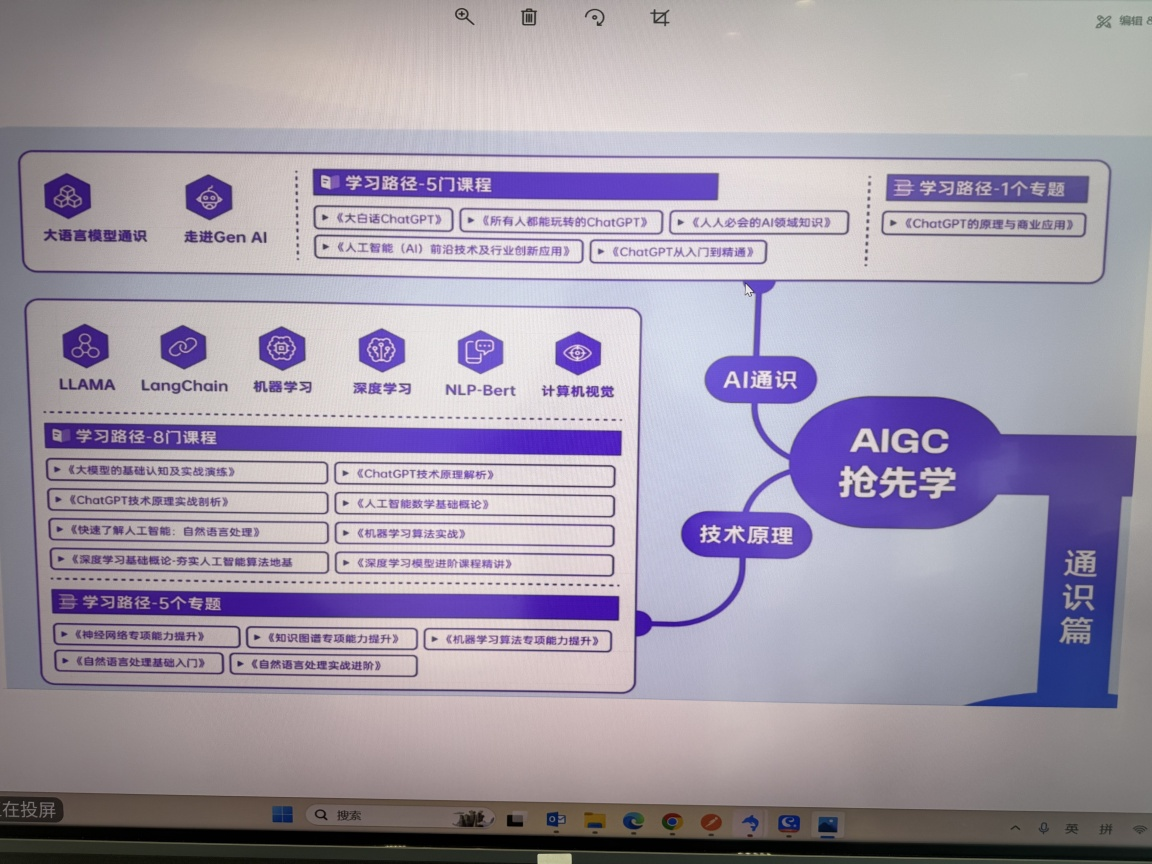

In [27]:
pil_image_resized

In [60]:
translated_image = _replace_translated_text(removed_text_image, translated_result)

{'font_color': '#595555', 'font_background_color': '#b2aeac', 'index': 0, 'original_text': '女', 'bounding_polygon': [650.0, 8.0, 671.0, 7.0, 671.0, 25.0, 650.0, 25.0], 'spans': [{'offset': 0, 'length': 1}], 'translated_text': '女'}
translated text:  女
single line text length:  1
max text width:  22.05 text size:  5.0
{'font_color': '#79857d', 'font_background_color': '#aeb6ae', 'font_style': 'normal', 'font_weight': 'bold', 'similar_font_family': 'BIZ UDGothic, SimHei, sans-serif', 'index': 1, 'original_text': '% 编辑 8', 'bounding_polygon': [1093.0, 12.0, 1150.0, 12.0, 1151.0, 28.0, 1093.0, 29.0], 'spans': [{'offset': 2, 'length': 6}], 'translated_text': '% 編集 8'}
translated text:  % 編集 8
single line text length:  6
max text width:  59.85 text size:  27.0
{'similar_font_family': 'BIZ UDGothic, SimHei, sans-serif', 'font_color': '#493569', 'font_background_color': '#968a96', 'font_style': 'normal', 'font_weight': 'bold', 'index': 2, 'original_text': '大语言模型通识', 'bounding_polygon': [40.0, 2

{'font_style': 'normal', 'font_weight': 'bold', 'font_color': '#9d8dad', 'font_background_color': '#e2d6e0', 'similar_font_family': 'SimHei, BIZ UDGothic, sans-serif', 'index': 8, 'original_text': '▶《人人必会的Al领域知识》', 'bounding_polygon': [675.0, 215.0, 830.0, 215.0, 830.0, 228.0, 675.0, 228.0], 'spans': [{'offset': 70, 'length': 14}], 'translated_text': '▶《人人必会のAI領域知識》'}
translated text:  ▶《人人必会のAI領域知識》
single line text length:  14
max text width:  162.75 text size:  69.0
{'font_weight': 'bold', 'font_style': 'normal', 'font_color': '#a18db1', 'font_background_color': '#ded4de', 'similar_font_family': 'SimHei, Meiryo, sans-serif', 'index': 9, 'original_text': '▶《人工智能(AI) 前沿技术及行业创新应用》', 'bounding_polygon': [319.0, 239.0, 570.0, 243.0, 570.0, 257.0, 319.0, 253.0], 'spans': [{'offset': 85, 'length': 23}], 'translated_text': '▶《人工知能(AI) 前沿技術及び業界の革新的な応用》'}
translated text:  ▶《人工知能(AI) 前沿技術及び業界の革新的な応用》
single line text length:  27
max text width:  263.55 text size:  128.0
{'font_style': 'normal

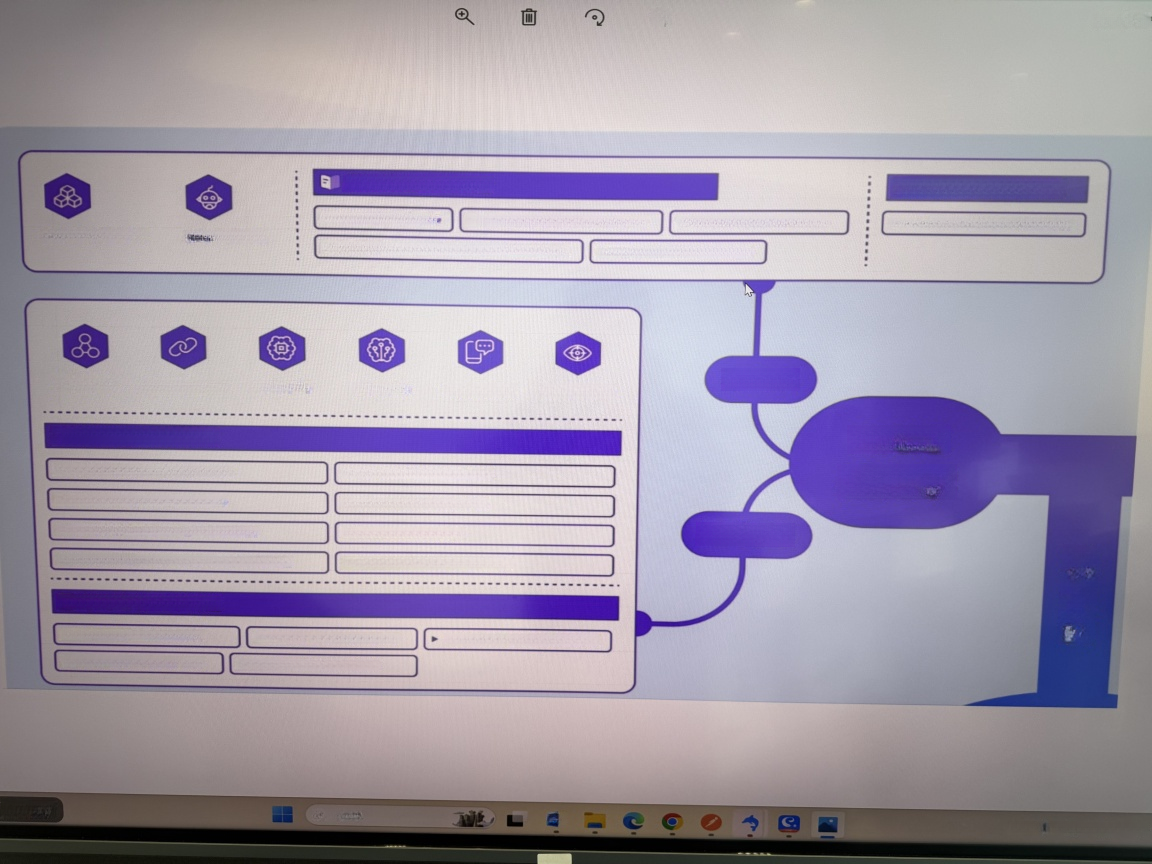

In [29]:
removed_text_image

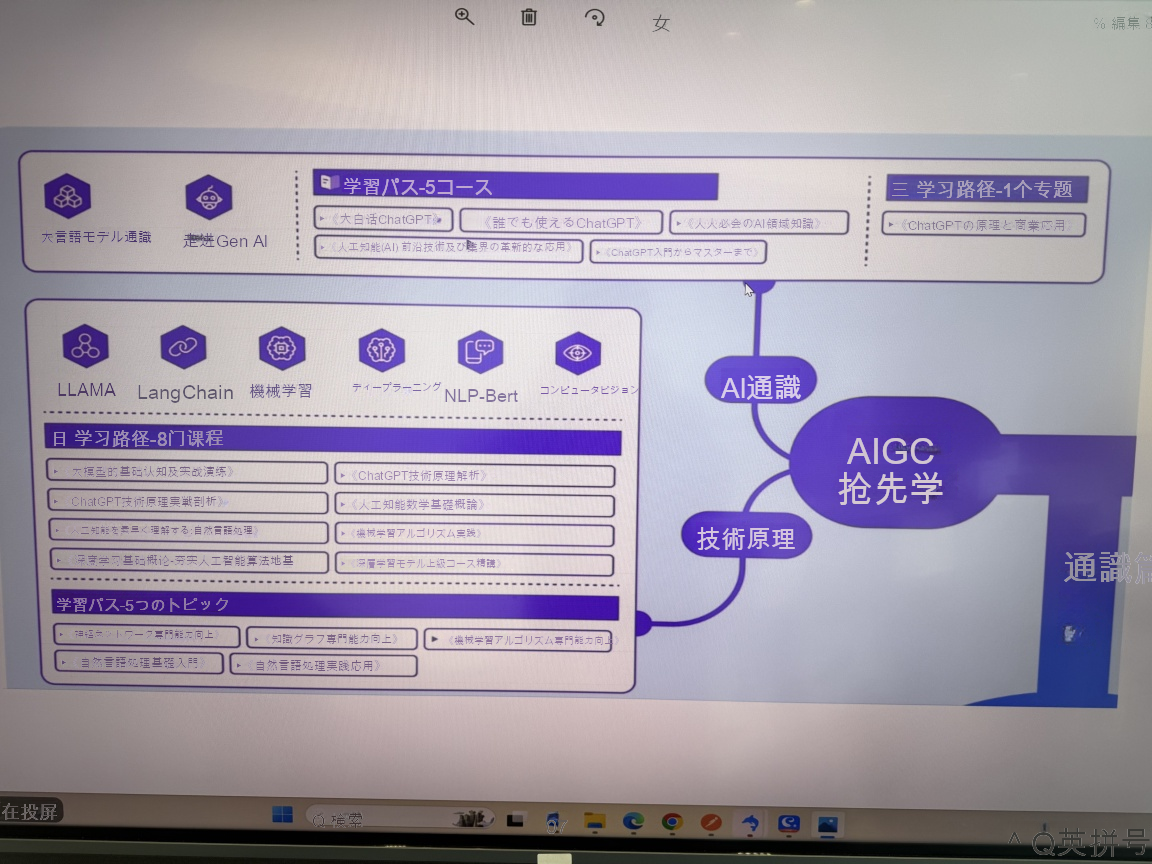

In [61]:
translated_image

In [44]:
def _resize_image(image_path):
    img = cv2.imread(image_path)
    scale_percent = 1152 / img.shape[1]
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    path, filename = os.path.split(image_path)
    base_filename, file_extension = os.path.splitext(filename)
    resized_image_path = os.path.join(path, base_filename + "_resized" + file_extension)
    cv2.imwrite(resized_image_path, resized)
    return resized_image_path

In [45]:
def translate_image(image_path, translate_to_language):
    resized_image_path = _resize_image(image_path)
    ocr_result = analyze_layout(resized_image_path)
    pil_image_resized = Image.open(resized_image_path)
    pil_mask = _draw_mask_box(pil_image_resized, ocr_result)
    removed_text_image = _text_removal(image_path, pil_mask)
    translated_result = loop.run_until_complete(_translate_using_gpt_batch(ocr_result, translate_to_language))
    translated_image = _replace_translated_text(removed_text_image, translated_result)
    return translated_image

In [48]:
translated_image = translate_image("./data/WechatIMG125.jpg", "jp")

TypeError: unhashable type: 'Image'